Global settings and import

In [1]:


from matplotlib import pyplot as plt

outputs=['RESULT_InclinationBeltDirection__deg_',
       'RESULT_Inclination90ToBeltDirection__deg_']


Columns after low variance filter and domain knowledge

In [2]:
with open("data\columns_domain.txt", "r") as file:
    columns = file.read().strip().split(",")

Import, NAN filter

In [3]:
from src.utils import load_raw
importer=load_raw.DataFrameImporter()
importer.load("0225","data/test 0225.csv")
#importer.NOK_Cleaning("100k",True)
importer.NAN_Cleaning("0225")
df1 = importer.get_dataframe("0225")
df1=df1[columns]





Outliers filter

In [4]:
from src.preprocess.outlier_filter import filter
df1_filtered=filter(df1,outputs)

c:\SVN\Python projects\Thesis Project\src\preprocess\outlier_filter.py:31: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  z_score = pd.concat([z_score, z_score_i])  # Append the result to z_score


Comparison of original and filtered data

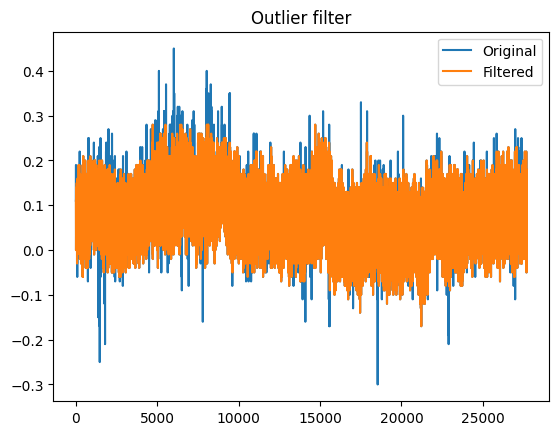

In [5]:
plt.plot(df1[outputs[0]],label="Original")
plt.plot(df1_filtered[outputs[0]], label="Filtered")
plt.title("Outlier filter")
plt.legend()
plt.show()


EDA

In [ ]:
from ydata_profiling import ProfileReport
import sweetviz as sv
profile = ProfileReport(df1_filtered, title="Ydata Profiling Report")
profile.to_file("eda_report\ydata_report_0225.html")
report = sv.analyze(df1_filtered, target_feat=outputs[0])
report.show_html('eda_report\sweetviz_report_BD_0225.html')


In [ ]:
import dtale
import dtale.global_state as global_state
global_state.set_chart_settings({'scatter_points': 200000, '3d_points': 40000})
dtale.show(df1_filtered)

Normalization and transformation

In [6]:
from sklearn.preprocessing import RobustScaler
inclination_toBD_original=df1_filtered[outputs[0]]
scaler = RobustScaler().fit(inclination_toBD_original.values.reshape(-1, 1))

In [7]:
inclination_toBD_original_scaled=scaler.transform(inclination_toBD_original.values.reshape(-1, 1)).flatten()


StatTest

Skewness: 0.018132830665169783
Shapiro-Wilk Test Statistic:=0.9972, p-value=0.0000
Data is not normally distributed
Kolmogorov-Smirnov Test: Statistic=0.0961, p-value=0.0000
Data is NOT normal (Reject H0)


c:\SVN\Python projects\Thesis Project\.venv\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


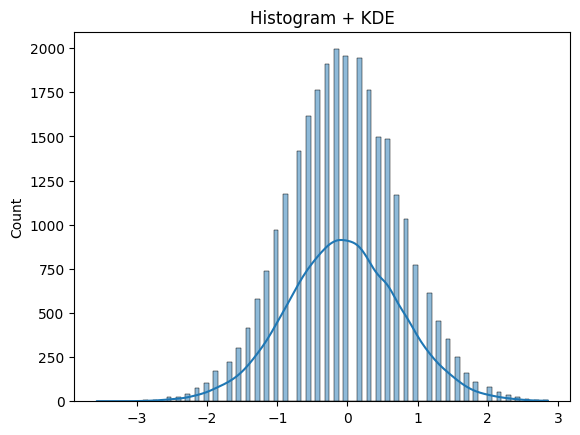

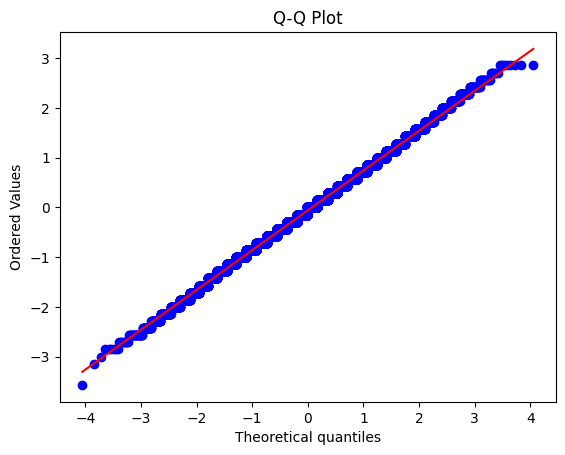

ADF Statistic: -7.393923886572032
p-value: 7.868551492199913e-11
Used Lags: 47
Number of Observations: 27300

Interpretation:
The p-value is 0.0000, which is less than 0.05.
This means the series is likely stationary.


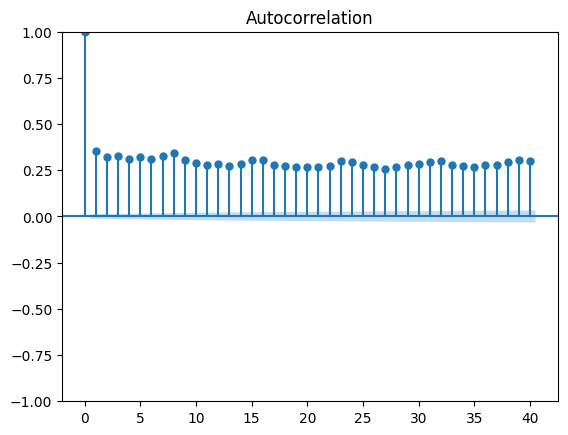

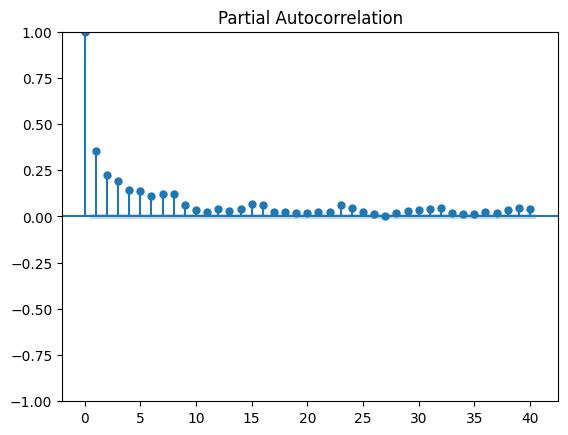

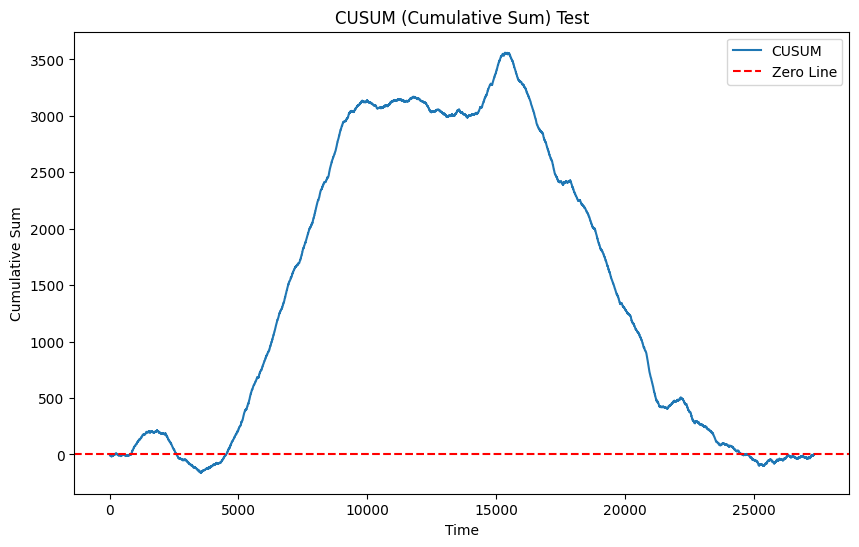

In [8]:
from src.evaluation import statests
import importlib
importlib.reload(statests)
statests.test_autoregression(inclination_toBD_original_scaled)
#statests.breakpoints(inclination_toBD_original_scaled)


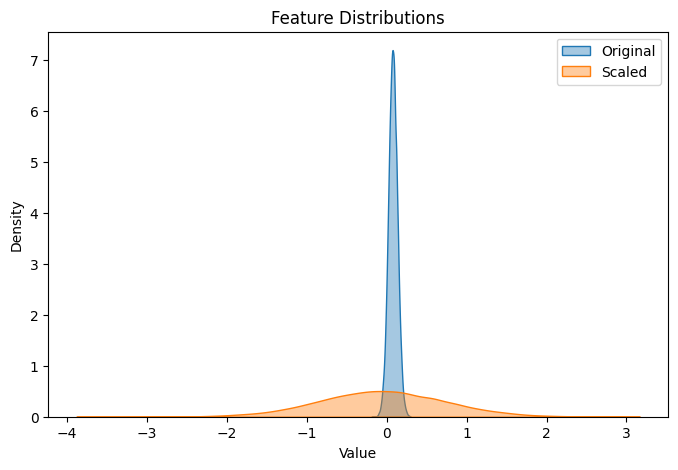

In [9]:
import seaborn as sns
plt.figure(figsize=(8, 5))
sns.kdeplot(inclination_toBD_original, label="Original", fill=True, alpha=0.4)
sns.kdeplot(inclination_toBD_original_scaled, label="Scaled", fill=True, alpha=0.4)
#plt.hist(inclination_toBD_original,bins=46,alpha=0.5,label="Original")
#plt.hist(inclination_toBD_original_scaled,bins=46,alpha=0.5, label="Scaled")
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Feature Distributions')
plt.legend()
plt.show()

In [10]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method='yeo-johnson')
inclination_toBD_original_scaled_transformed_pt=pt.fit_transform(inclination_toBD_original_scaled.reshape(-1,1)).flatten()



Smoothing

In [11]:

from src.preprocess import smoothing
import pandas as pd


#methods=['MA', 'Gaussian', 'Wavelet', 'RTS']
datasmoothing = smoothing.DataSmoothing(inclination_toBD_original_scaled_transformed_pt, methods=['Gaussian','RTS'], max_lag=50)
smoothed=datasmoothing.get_smoothed_data()



Smoothing tests

In [ ]:
denoised_data_test = pd.DataFrame(datasmoothing.compare_smoothing_methods())
print(denoised_data_test)

In [12]:

inclination_toBD_sc_tr_sm=smoothed['Noisy Data']
#statests.test_autoregression(inclination_toBD_sc_tr_sm)

In [ ]:
inclination_toBD_sc_tr_sm=smoothed['Gaussian Filter']
statests.test_autoregression(inclination_toBD_sc_tr_sm)

In [ ]:
inclination_toBD_sc_tr_sm=smoothed['RTS Smoothing']
#statests.test_autoregression(inclination_toBD_sc_tr_sm)

Regression

In [13]:
from src.regression import regression_pycaret as rpc
import importlib
importlib.reload(rpc)
regression=rpc.RegressionPyCaret(inclination_toBD_sc_tr_sm)
regression.create_lagged_features()
regression.setup_and_train_models(['lr', 'ridge', 'lightgbm']) #['lr', 'ridge', 'lightgbm', 'rf']
regression_results=regression.predict()
regression_results=pd.DataFrame(regression_results)

Splitting data before training models...


,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(21782, 101)"
4,Transformed data shape,"(21782, 101)"
5,Transformed train set shape,"(16337, 101)"
6,Transformed test set shape,"(5445, 101)"
7,Numeric features,100


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lr,Linear Regression,0.6834,0.7337,0.8545,0.0580,0.4069,1.3906,1.9020
ridge,Ridge Regression,0.6834,0.7337,0.8545,0.0580,0.4069,1.3906,0.4110
lightgbm,Light Gradient Boosting Machine,0.6947,0.7585,0.8686,0.0277,0.4104,1.4090,0.4970


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,0.6891,0.7359,0.8578,0.0251,0.4392,1.1885


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,0.6891,0.7359,0.8578,0.0251,0.4392,1.1885


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.6920,0.7430,0.8619,0.0158,0.4341,1.2269
